In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [44]:
data = pd.read_csv("s3://ai-diennea/data/export_wonkit_20210630102441.csv.gz")
# add the day of the week column
day_of_week = []
for i in range(len(data)):
    day_of_week.append(pd.to_datetime(data["EVENT.DATE"][i], format='%Y/%m/%d %H:%M').day_name())
data['day_of_week'] = pd.DataFrame(day_of_week)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [49]:
def sent_date_to_min(sents):
    return sents.hour*60 + sents.minute

def from_min_to_hour_and_min(mins):
    hours = round(mins) // 60
    minutes = round(mins) % 60
    return "{}:{}".format(hours, minutes)


def exp_decay_fit(x, sent_open_hour_range):
    if x > sent_open_hour_range*60:
        return .0
    if x < 0:
        return 1
    return math.exp(((-math.log(2)/(sent_open_hour_range*60))*x) + math.log(2))-1


def compute_fitSA(hash_mex, hash_contact, sent_open_hour_range, data):
    sents, opens, clicks = [], [], []
    list_index = get_all_indexes(hash_mex, hash_contact, data)
    for i in list_index:
        if data['EVENT.TYPE'][i] == 'Sent':
            sents.append(pd.to_datetime(data["EVENT.DATE"][i], format='%Y/%m/%d %H:%M'))
        elif data['EVENT.TYPE'][i] == 'Open':
            opens.append(pd.to_datetime(data["EVENT.DATE"][i], format='%Y/%m/%d %H:%M'))
        elif data['EVENT.TYPE'][i] == 'Click':
            clicks.append(pd.to_datetime(data["EVENT.DATE"][i], format='%Y/%m/%d %H:%M'))
    
    y = sent_date_to_min(sents[0]) # since this function gives me for free the y, I return it here
    # if there are multiple opens/clicks, take the oldest one (the first that has been opened/clicked)
    oldest = None
    if opens != []:
        for i in opens:
            if oldest is None:
                oldest = i
            elif i < oldest:
                oldest = i
    elif clicks != []:
        for i in clicks:
            if oldest is None:
                oldest = i
            elif i < oldest:
                oldest = i
    else: # this means that the mail has never been opened/clicked
        return .0, y

    # compute minutes of the distance between sent-open/sent-click
    mins = ((oldest - sents[0]).days*24*60) + ((oldest - sents[0]).seconds//3600)*60 + ((oldest - sents[0]).seconds//60)%60

    return exp_decay_fit(mins, sent_open_hour_range), y

def compute_fitAC(hash_mex, hash_contact, open_click_hour_range, data):
    opens, clicks = [], []

    list_index = get_all_indexes(hash_mex, hash_contact, data)
    for i in list_index:
        if data['EVENT.TYPE'][i] == 'Open':
            opens.append(pd.to_datetime(data["EVENT.DATE"][i], format='%Y/%m/%d %H:%M'))
        elif data['EVENT.TYPE'][i] == 'Click':
            clicks.append(pd.to_datetime(data["EVENT.DATE"][i], format='%Y/%m/%d %H:%M'))
    
    oldest_open = None
    oldest_click = None

    if opens == [] and clicks != []: # messege clicked but open is not detected: I assign -1 and then a function
        return -1                    # computes the avg
    
    if clicks == []: # covers cases when a message is sent and is never open and never clicked
        return .0
    elif opens != [] and clicks != []:
        for i in opens: # get oldest open
            if oldest_open is None:
                oldest_open = i
            elif i < oldest_open:
                oldest_open = i
        for i in clicks: # get oldest click
            if oldest_click is None:
                oldest_click = i
            elif i < oldest_click:
                oldest_click = i
    # compute minutes of the distance between sent-open/sent-click
    mins = ((oldest_click - oldest_open).days*24*60) + ((oldest_click - oldest_open).seconds//3600)*60 + ((oldest_click - oldest_open).seconds//60)%60
    return exp_decay_fit(mins, open_click_hour_range)

def avg_fitAC(df):
    fitAC_column = df['fitAC'].to_list()
    l = []
    for i in fitAC_column:
        if i != -1:
            l.append(i)
    return statistics.mean(l)


# (messaggi aperti fascia oraria 0-1 / numero totali di mail aperte in generale dal contatto)
def open_rate_mex_time_slot(hash_contact, data): # TODO: add parameter for [0, 24]
    mex_plus_contact_distinct = []
    dates = []
    list_index = get_all_indexes_contact(hash_contact, data)
    for i in list_index:
        if "nan" not in str(data["EVENT.DATE"][i]) and str(data["EVENT.TYPE"][i]) == 'Open' and (data["HashMessaggio"][i] + data['HashContatto'][i]) not in mex_plus_contact_distinct:
            mex_plus_contact_distinct.append(data["HashMessaggio"][i] + data['HashContatto'][i])
            dates.append(pd.to_datetime(data["EVENT.DATE"][i], format='%Y/%m/%d %H:%M'))
    # add messages clicked but not opened
    for i in list_index:
        if "nan" not in str(data["EVENT.DATE"][i]) and str(data["EVENT.TYPE"][i]) == 'Click' and (data["HashMessaggio"][i] + data['HashContatto'][i]) not in mex_plus_contact_distinct:
            mex_plus_contact_distinct.append(data["HashMessaggio"][i] + data['HashContatto'][i])
            dates.append(pd.to_datetime(data["EVENT.DATE"][i], format='%Y/%m/%d %H:%M'))

    tot_mex_opened = len(mex_plus_contact_distinct)
    if len(dates) == 0: # it means that the user has never opened messages
        return np.zeros((24,))
    df = pd.DataFrame(dates, columns =['dates'])

    df = df.assign(session=pd.cut(df["dates"].dt.hour,
                                [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24],
                                labels=['0-1','1-2','2-3','3-4','4-5','5-6','6-7', '7-8', '8-9', '9-10', '10-11', '11-12', '12-13', '13-14', '14-15', '15-16', '16-17', '17-18', '18-19', '19-20', '20-21', '21-22', '22-23', '23-24'],
                                include_lowest=True))
    numpy_output = df['session'].value_counts().sort_index().to_numpy() / tot_mex_opened

    return numpy_output


def dp_open_rate_mex_time_slot(data):
    d = {}
    for i in data["HashContatto"].unique():
        if i not in d:
            d[i] = None
    for key in d:
        d[key] = open_rate_mex_time_slot(key, data)

    return d


# (messaggi clickati fascia oraria 0-1 / numero totali di mail clickate in generale)
def click_rate_mex_time_slot(hash_contact, data): # TODO: add parameter for [0, 24]
    mex_plus_contact_distinct = []
    dates = []
    list_index = get_all_indexes_contact(hash_contact, data)
    for i in list_index:
        if "nan" not in str(data["EVENT.DATE"][i]) and str(data["EVENT.TYPE"][i]) == 'Click' and (data["HashMessaggio"][i] + data['HashContatto'][i]) not in mex_plus_contact_distinct:
            mex_plus_contact_distinct.append(data["HashMessaggio"][i] + data['HashContatto'][i])
            dates.append(pd.to_datetime(data["EVENT.DATE"][i], format='%Y/%m/%d %H:%M'))

    tot_mex_opened = len(mex_plus_contact_distinct)
    if len(dates) == 0: # it means that the user has never clicked messages
        return np.zeros((24,))
    df = pd.DataFrame(dates, columns =['dates'])

    df = df.assign(session=pd.cut(df["dates"].dt.hour,
                                [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24],
                                labels=['0-1','1-2','2-3','3-4','4-5','5-6','6-7', '7-8', '8-9', '9-10', '10-11', '11-12', '12-13', '13-14', '14-15', '15-16', '16-17', '17-18', '18-19', '19-20', '20-21', '21-22', '22-23', '23-24'],
                                include_lowest=True))
    

    numpy_output = df['session'].value_counts().sort_index().to_numpy() / tot_mex_opened
    return numpy_output

def dp_click_rate_mex_time_slot(data):
    d = {}
    for i in data["HashContatto"].unique():
        if i not in d:
            d[i] = None
    for key in d:
        d[key] = click_rate_mex_time_slot(key, data)

    return d

# numero di messaggi aperti tra le 0-1 di quella Comm / Quanti messaggi distinti sono stati aperti/clickati in quella comunicazione
# return a dict where in `d[key]['time_slot_distribution']` there is the 24 vector time slot distribution
def rate_comm_time_slot(data, open_or_click):
    if open_or_click != 'Open' and open_or_click != 'Click':
        raise Exception('open_or_click value must be either \'Open\' or \'Click\'') 
    d = {}
    for i in data["COMUNICATION.COMUNICATION_NAME"].unique():
        if i not in d:
            d[i] = {'tot_open': 0, 'dates': [], 'time_slot_distribution': None}

    for comm in data['COMUNICATION.COMUNICATION_NAME'].unique():
        mex_plus_contact_distinct = []
        list_index = get_indexes_of_comm(comm, data)
        for i in list_index:
            if str(data["EVENT.TYPE"][i]) == open_or_click and (data["HashMessaggio"][i] + data['HashContatto'][i]) not in mex_plus_contact_distinct:
                mex_plus_contact_distinct.append(data["HashMessaggio"][i] + data['HashContatto'][i])
                d[data['COMUNICATION.COMUNICATION_NAME'][i]]['tot_open'] += 1
                d[data['COMUNICATION.COMUNICATION_NAME'][i]]['dates'].append(pd.to_datetime(data["EVENT.DATE"][i], format='%Y/%m/%d %H:%M'))
    for key, value in d.items():
        if len(d[key]['dates']) == 0: # it means that the communcation has never been opened
            return np.zeros((24,))
        df = pd.DataFrame(d[key]['dates'], columns =['dates'])

        df = df.assign(session=pd.cut(df["dates"].dt.hour,
                                    [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24],
                                    labels=['0-1','1-2','2-3','3-4','4-5','5-6','6-7', '7-8', '8-9', '9-10', '10-11', '11-12', '12-13', '13-14', '14-15', '15-16', '16-17', '17-18', '18-19', '19-20', '20-21', '21-22', '22-23', '23-24'],
                                    include_lowest=True))

        d[key]['time_slot_distribution'] = df['session'].value_counts().sort_index().to_numpy() / d[key]['tot_open']

    return d

def compute_fitSA_evaluation(hash_mex, hash_contact, sent_open_hour_range, data, sent_pred):
    opens, clicks = [], []
    sent_pred = from_min_to_hour_and_min(sent_pred)
    list_index = get_all_indexes(hash_mex, hash_contact, data)
    for i in list_index:
        if data['EVENT.TYPE'][i] == 'Open':
            opens.append(pd.to_datetime(data["EVENT.DATE"][i], format='%Y/%m/%d %H:%M'))
        elif data['EVENT.TYPE'][i] == 'Click':
            clicks.append(pd.to_datetime(data["EVENT.DATE"][i], format='%Y/%m/%d %H:%M'))
    oldest = None
    if opens != []:
        for i in opens:
            if oldest is None:
                oldest = i
            elif i < oldest:
                oldest = i
    elif clicks != []:
        for i in clicks:
            if oldest is None:
                oldest = i
            elif i < oldest:
                oldest = i
    else: # this means that the mail has never been opened/clicked
        return .0
    oldest = str(oldest.hour) +":"+ str(oldest.minute)
    oldest = pd.to_datetime(oldest, format='%H:%M')
    sent_pred = pd.to_datetime(sent_pred, format='%H:%M')
    # compute minutes of the distance between sent-open/sent-click
    mins = ((oldest - sent_pred).days*24*60) + ((oldest - sent_pred).seconds//3600)*60 + ((oldest - sent_pred).seconds//60)%60
    return exp_decay_fit(mins, sent_open_hour_range)

# TODO: "la FOP si trova tra Open e Click reali", this evaluate is based only on fitSA, need to compute also fitAC?
def evaluate(df, X, data, sent_open_hour_range, preds):  
    # from [0, 1] to mins, TODO: note that this going back produces "a lot" of discretization
    for i in range(len(preds)):
        preds[i] *= 1022 # this 1022 is the max_y that was needed to convert mins into [0, 1]
    
    # dict that contains for each contact, its messages
    dk = {}
    for cont in df['HashContatto'].unique():
        if cont not in dk:
            dk[cont] = {'HashMessaggio': []}

    for i in range(len(df)):
        dk[df['HashContatto'][i]]['HashMessaggio'].append(df['HashMessaggio'][i])

    curr = 0                                           
    fitSA_preds = []                                   
    for cont in dk:
        for mex in dk[cont]['HashMessaggio']:
            fitSA_preds.append(compute_fitSA_evaluation(mex, cont, sent_open_hour_range, data, preds[curr]))
            curr += 1
    total_mex = len(fitSA_preds)
    predicted_sent_better_than_usual_sent = 0

    for i in range(total_mex):
        if fitSA_preds[i] > X.iloc[i, 97]: # new postion of fitSA # TODO: what to do in case is equal?
            predicted_sent_better_than_usual_sent += 1

    return predicted_sent_better_than_usual_sent/total_mex

def avg_for_new_contact(X):
    open_rate_avg = X[["OR 0-1", "OR 1-2", "OR 2-3", "OR 3-4", "OR 4-5", "OR 5-6", "OR 6-7", "OR 7-8", "OR 8-9", "OR 9-10", "OR 10-11", "OR 11-12",
    "OR 12-13", "OR 13-14", "OR 14-15", "OR 15-16", "OR 16-17", "OR 17-18", "OR 18-19", "OR 19-20", "OR 20-21", "OR 21-22", "OR 22-23", "OR 23-24"]].mean()

    click_rate_avg = X[["CR 0-1", "CR 1-2", "CR 2-3", "CR 3-4", "CR 4-5", "CR 5-6", "CR 6-7", "CR 7-8", "CR 8-9", "CR 9-10", "CR 10-11", "CR 11-12",
    "CR 12-13", "CR 13-14", "CR 14-15", "CR 15-16", "CR 16-17", "CR 17-18", "CR 18-19", "CR 19-20", "CR 20-21", "CR 21-22", "CR 22-23", "CR 23-24"]].mean()

    open_rate_comm = X[["OR-C 0-1", "OR-C 1-2", "OR-C 2-3", "OR-C 3-4", "OR-C 4-5", "OR-C 5-6", "OR-C 6-7", "OR-C 7-8", "OR-C 8-9", "OR-C 9-10", "OR-C 10-11", "OR-C 11-12", 
    "OR-C 12-13", "OR-C 13-14", "OR-C 14-15", "OR-C 15-16", "OR-C 16-17", "OR-C 17-18", "OR-C 18-19", "OR-C 19-20", "OR-C 20-21", "OR-C 21-22", "OR-C 22-23", "OR-C 23-24"]].mean()

    click_rate_comm = X[["CR-C 0-1", "CR-C 1-2", "CR-C 2-3", "CR-C 3-4", "CR-C 4-5", "CR-C 5-6", "CR-C 6-7", "CR-C 7-8", "CR-C 8-9", "CR-C 9-10", "CR-C 10-11", "CR-C 11-12", 
    "CR-C 12-13", "CR-C 13-14", "CR-C 14-15", "CR-C 15-16", "CR-C 16-17", "CR-C 17-18", "CR-C 18-19", "CR-C 19-20", "CR-C 20-21", "CR-C 21-22", "CR-C 22-23", "CR-C 23-24"]].mean()
    return open_rate_avg, click_rate_avg, open_rate_comm, click_rate_comm

def get_sent_hour(model, hash_contatto, df, X):
    if hash_contatto in df['HashContatto'].unique():
        features_contatto = X.iloc[df.index[(df['HashContatto'] == hash_contatto)][0], :].to_numpy() # TODO: here I take just the first feature. But a contact has different features because each contact has more messages and each message has different comunication. So, in order to choose the best hour for each contact, a possible option would be to take the one with the higest fitSA / fitAC, or the hour that appears more time.
        features_contatto = features_contatto.reshape(-1, 1).T
        preds = model.predict(features_contatto)
        # from [0, 1] to mins
        mins = preds[0] * 1022 # this 1022 is the max_y that was needed to convert mins into [0, 1]
        return from_min_to_hour_and_min(mins)
    else:
        open_rate_avg, click_rate_avg, open_rate_comm, click_rate_comm = avg_for_new_contact(X)
        new_row = pd.DataFrame(0, index=np.arange(1), columns=X.columns) 
        new_row.iloc[0, 0:24] = open_rate_avg
        new_row.iloc[0, 24:48] = click_rate_avg
        new_row.iloc[0, 48:72] = open_rate_comm
        new_row.iloc[0, 72:96] = click_rate_comm
        # for inference, we put the fits to 1 # TODO: do we need to set to one also in the upper case?
        new_row.iloc[0, 96] = 1 # fitSA
        new_row.iloc[0, 97] = 1 # fitCA
        preds = model.predict(new_row)
        # from [0, 1] to mins
        mins = preds[0] * 1022 # this 1022 is the max_y that was needed to convert mins into [0, 1]
        return from_min_to_hour_and_min(mins)


def get_index_for_comm(hash_mex, hash_contact, data):
    return data.index[(data['HashMessaggio'] == hash_mex) & (data['HashContatto'] == hash_contact)][0] # get first index because the others are the same

def get_all_indexes(hash_mex, hash_contact, data):
    return data.index[(data['HashMessaggio'] == hash_mex) & (data['HashContatto'] == hash_contact)]

def get_all_indexes_contact(hash_contact, data):
    return data.index[(data['HashContatto'] == hash_contact)]

def get_indexes_of_comm(comm, data):
    return data.index[(data['COMUNICATION.COMUNICATION_NAME'] == comm)]

In [46]:
column_names = ["HashContatto",  "HashMessaggio", "OR 0-1", "OR 1-2", "OR 2-3", "OR 3-4", "OR 4-5", "OR 5-6", "OR 6-7", "OR 7-8", "OR 8-9", "OR 9-10", "OR 10-11", "OR 11-12",
"OR 12-13", "OR 13-14", "OR 14-15", "OR 15-16", "OR 16-17", "OR 17-18", "OR 18-19", "OR 19-20", "OR 20-21", "OR 21-22", "OR 22-23", "OR 23-24",

"CR 0-1", "CR 1-2", "CR 2-3", "CR 3-4", "CR 4-5", "CR 5-6", "CR 6-7", "CR 7-8", "CR 8-9", "CR 9-10", "CR 10-11", "CR 11-12",
"CR 12-13", "CR 13-14", "CR 14-15", "CR 15-16", "CR 16-17", "CR 17-18", "CR 18-19", "CR 19-20", "CR 20-21", "CR 21-22", "CR 22-23", "CR 23-24",

"OR-C 0-1", "OR-C 1-2", "OR-C 2-3", "OR-C 3-4", "OR-C 4-5", "OR-C 5-6", "OR-C 6-7", "OR-C 7-8", "OR-C 8-9", "OR-C 9-10", "OR-C 10-11", "OR-C 11-12", 
"OR-C 12-13", "OR-C 13-14", "OR-C 14-15", "OR-C 15-16", "OR-C 16-17", "OR-C 17-18", "OR-C 18-19", "OR-C 19-20", "OR-C 20-21", "OR-C 21-22", "OR-C 22-23", "OR-C 23-24",

"CR-C 0-1", "CR-C 1-2", "CR-C 2-3", "CR-C 3-4", "CR-C 4-5", "CR-C 5-6", "CR-C 6-7", "CR-C 7-8", "CR-C 8-9", "CR-C 9-10", "CR-C 10-11", "CR-C 11-12", 
"CR-C 12-13", "CR-C 13-14", "CR-C 14-15", "CR-C 15-16", "CR-C 16-17", "CR-C 17-18", "CR-C 18-19", "CR-C 19-20", "CR-C 20-21", "CR-C 21-22", "CR-C 22-23", "CR-C 23-24",
"fitSA", "fitAC", "Label"]
sent_open_hour_range = 36
open_click_hour_range = 24

df = pd.DataFrame(columns = column_names)

def create_dataset(data, sent_open_hour_range, open_click_hour_range, column_names):
    df = pd.DataFrame(0, index=np.arange((len(data['HashContatto'].unique()) + len(data['HashMessaggio'].unique()))), columns=column_names) 
    open_rate_comm_dict = rate_comm_time_slot(data, 'Open')
    click_rate_comm_dict = rate_comm_time_slot(data, 'Click')
    # dict that contains for each contact, its messages
    dk = {}
    for cont in data['HashContatto'].unique():
        if cont not in dk:
            dk[cont] = {'HashMessaggio': []}

    for i in range(len(data)):
        dk[data['HashContatto'][i]]['HashMessaggio'].append(data['HashMessaggio'][i])

    for key in dk:
        vals = list(set(dk[key]['HashMessaggio']))
        dk[key]['HashMessaggio'] = vals
    # create dataset row by row
    current = 0
    for cont in dk:
        for mex in dk[cont]['HashMessaggio']:
            # HashContatto
            df.iloc[current, 0] = cont
            # HashMessaggio
            df.iloc[current, 1] = mex
            fitSA, y = compute_fitSA(mex, cont, sent_open_hour_range, data)
            # Label "Sent"
            df.iloc[current, 100] = y
            # fitSA
            df.iloc[current, 98] = fitSA
            # fitAC
            fitAC = compute_fitAC(mex, cont, open_click_hour_range, data)
            df.iloc[current, 99] = fitAC
            # index for compute opens and clicks of communication
            index_comm = get_index_for_comm(mex, cont, data)
            # open rate communication
            df.iloc[current, 50:74] = open_rate_comm_dict[data['COMUNICATION.COMUNICATION_NAME'][index_comm]]['time_slot_distribution']
            # click rate communication
            df.iloc[current, 74:98] = click_rate_comm_dict[data['COMUNICATION.COMUNICATION_NAME'][index_comm]]['time_slot_distribution']
            current += 1
            if current % 1000 == 0:
                print(current)
    
    df = df.iloc[:current, :] # delete le row di troppo
    # convert in minutes and then into [0, 1]
    max_y = -1
    for i in range(len(df)):
        if df.iloc[i, 100] > max_y:
            max_y = df.iloc[i, 100]
    for i in range(len(df)):
        df.iloc[i, 100] /= max_y
    # open 24
    d = dp_open_rate_mex_time_slot(data) # dict that contains the open rate time slot for each contact
    for i in range(len(df)):
         df.iloc[i, 2:26] = d[df.iloc[i, 0]] # df.iloc[i, 0] is HashContatto
    # click 24
    d2 = dp_click_rate_mex_time_slot(data) # dict that contains the click rate time slot for each contact
    for i in range(len(df)):
         df.iloc[i, 26:50] = d2[df.iloc[i, 0]] # df.iloc[i, 0] is HashContatto
    # clicked but not opened have fitAC as -1, so we assign the average of the fitAC of mex cicked and opened
    avgAC = avg_fitAC(df)

    for i in range(len(df)):
        if df['fitAC'][i] == -1:
            df['fitAC'][i] = avgAC
    hash_contact = df['HashContatto']
    y = df['Label']
    X = df.drop(['HashMessaggio', 'HashContatto', 'Label'], axis=1)
    return df, X, y, hash_contact

In [53]:
df, X, y, hash_contact = create_dataset(data, sent_open_hour_range, open_click_hour_range, column_names)

KeyboardInterrupt: 

In [30]:
df_train, df_test = train_test_split(df, test_size=0.30, random_state=42)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

In [32]:
regr = RandomForestRegressor(max_depth=2)
regr.fit(X_train, y_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


RandomForestRegressor(max_depth=2)

## Test on training set

In [135]:
preds = regr.predict(X_train)

In [201]:
evaluate(df_train, X_train, data, sent_open_hour_range, preds)

0.23406455587581684

## Test on test set

In [202]:
preds = regr.predict(X_test)

In [203]:
evaluate(df_test, X_test, data, sent_open_hour_range, preds)

0.23255813953488372

In [204]:
# TODO: how to handle nuovi contatti? just create a function with model as param and set to it the avg of the features?

## Save things

In [1]:
df.to_csv("s3://ai-diennea/data/df.csv")

NameError: name 'df' is not defined

In [206]:
X.to_csv("s3://ai-diennea/data/X.csv")

In [207]:
y.to_csv("s3://ai-diennea/data/y.csv")

In [208]:
hash_contact.to_csv("s3://ai-diennea/data/hash_contact.csv")

## Load things

In [58]:
df = pd.read_csv("s3://ai-diennea/data/df.csv")
df = df.drop(['Unnamed: 0'], axis=1)

In [6]:
X = pd.read_csv("s3://ai-diennea/data/X.csv")
X = X.drop(['Unnamed: 0'], axis=1)

In [7]:
y = pd.read_csv("s3://ai-diennea/data/y.csv")
y = y.drop(['Unnamed: 0'], axis=1)

In [8]:
hash_contact = pd.read_csv("s3://ai-diennea/data/hash_contact.csv")
hash_contact = hash_contact.drop(['Unnamed: 0'], axis=1)

## Fit model

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.30, random_state=42)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

In [ ]:
regr = RandomForestRegressor(max_depth=2)
regr.fit(X_train, y_train)

## Predict hour for a given contact

In [106]:
hash_contatto = df['HashContatto'].unique()[0]
get_sent_hour(regr, hash_contatto, df, X)

'14:56'

In [127]:
l = []
for i in range(len(df['HashContatto'].unique())):
    l.append(get_sent_hour(regr, df['HashContatto'].unique()[i], df, X))

<AxesSubplot:>

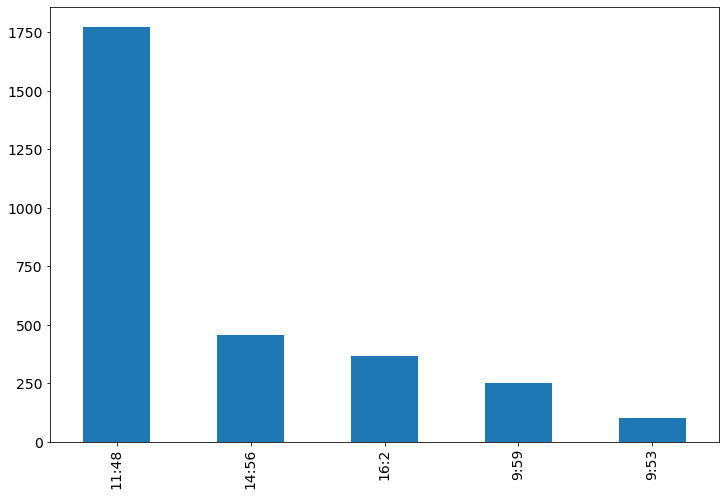

In [131]:
pd.Series(l).value_counts().plot(kind='bar')